## Import

In [1]:
import numpy as np
from colorednoise import powerlaw_psd_gaussian
from scipy.signal import chirp
import matplotlib.pyplot as plt
from neurodsp.plts import plot_power_spectra
from neurodsp.spectral import compute_spectrum

## Parameters

In [2]:
srate = 256
datalength = 5
pi = np.pi
# time vector
t = np.linspace(0,datalength,datalength*srate)

# amplitude of the 2 components
noiseamp = 1
ff = .3
kk = .25
amp = 2*(kk*np.sin(2*pi*ff*t)**2+(1-kk))

# make demeaned colored noise
e = 1.5
cn = powerlaw_psd_gaussian(e,srate*datalength)
cn = cn - np.mean(cn)

# make oscillation data
#freq = 10;oscil = amp.*sin(2*pi*freq.*t+(2*pi*rand));
freq = 8
oscil=amp*chirp(t,freq,5,freq+4)

# combine
data = oscil + (noiseamp*cn)

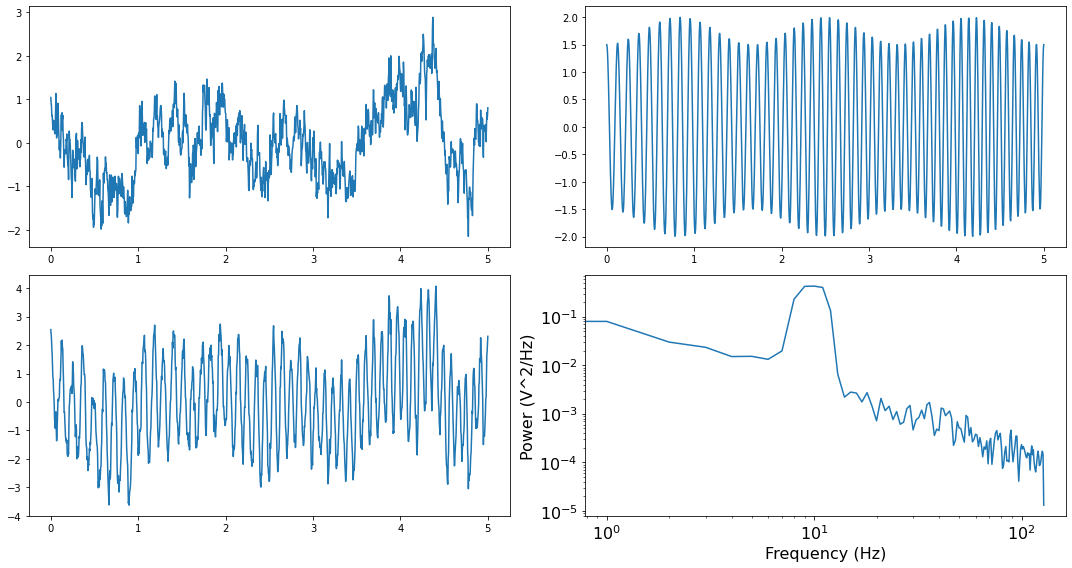

In [3]:
fig, axs = plt.subplots(2,2,figsize = (15,8))

# Noise
axs[0][0].plot(t,cn)

# Oscillations
axs[0][1].plot(t,oscil)

# Combined
axs[1][0].plot(t,data)

# PSD
freq, power = compute_spectrum(data,srate)
plot_power_spectra(freq, power,ax=axs[1][1])

## FOOOF


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 128 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                         

Text(0.5, 1.0, 'AP Fit')

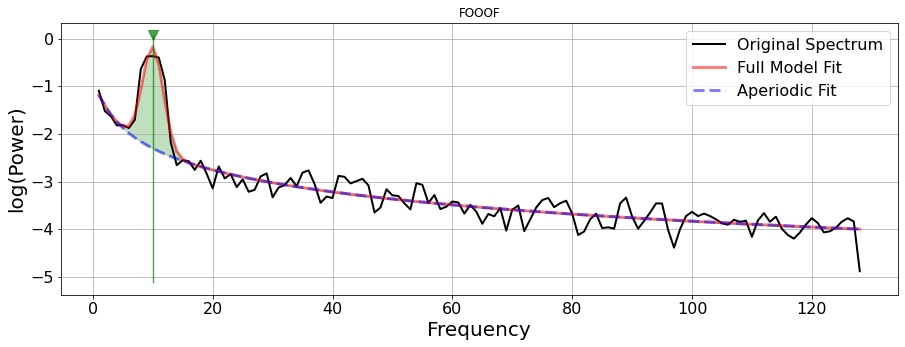

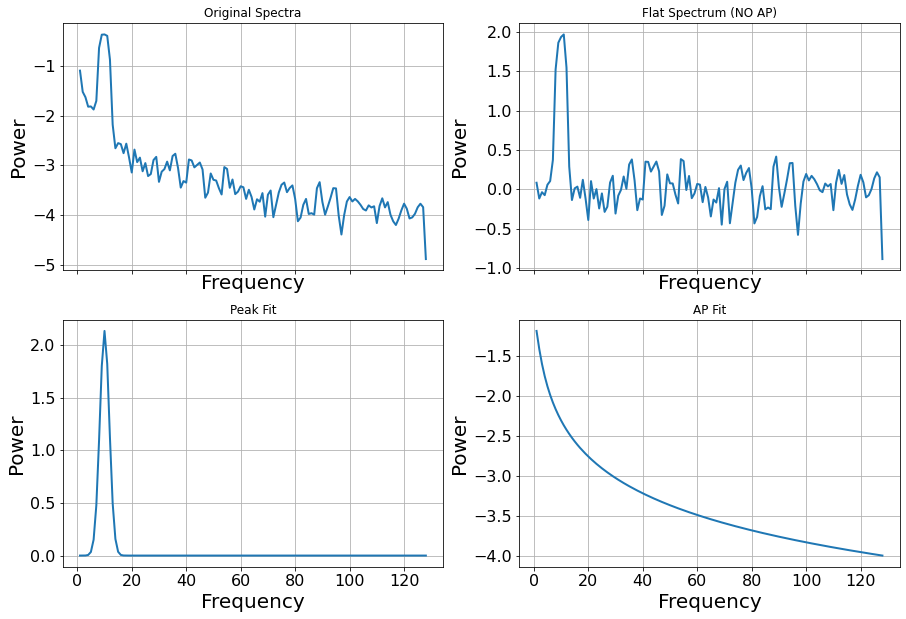

In [4]:
from fooof import FOOOF
from fooof.plts import plot_spectrum


fm = FOOOF(aperiodic_mode='knee', verbose=True, max_n_peaks=1)
fm.fit(freq, power)
fm.print_results()

fig, ax = plt.subplots(figsize=[15, 5])
fm.plot(plot_peaks='line-shade', ax=ax)
plt.title("FOOOF")

# Visualization of spectra parametrization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex=True,figsize=[15, 10])
plot_spectrum(fm.freqs,fm.power_spectrum,ax=ax1)
ax1.set_title("Original Spectra")

plot_spectrum(fm.freqs,fm._spectrum_flat,ax=ax2)
ax2.set_title("Flat Spectrum (NO AP)")

plot_spectrum(fm.freqs,fm._peak_fit,ax=ax3)
ax3.set_title("Peak Fit")

plot_spectrum(fm.freqs,fm._ap_fit,ax=ax4)
ax4.set_title("AP Fit")

## BACK TO TIME

c:\Users\Giovanni\OneDrive - Politecnico di Torino\PhD\MissionsAbroad\Gand 2022\BCI\venv\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


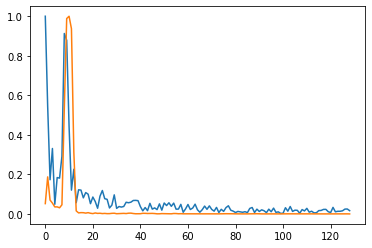

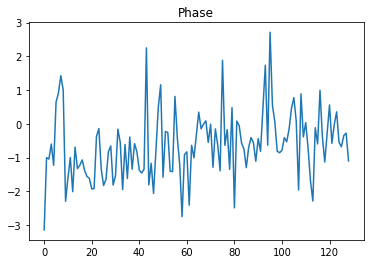

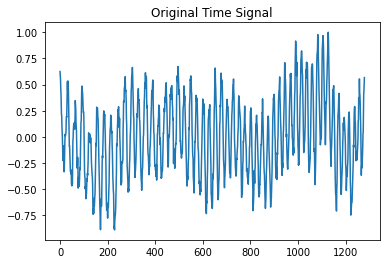

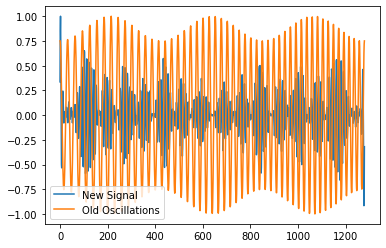

In [6]:
from scipy.fft import fft, ifft

peak_fit = fm._peak_fit
out = fft(data,len(freq)*2)
out = out[0:len(out)//2]
fft_power = np.abs(out)

fft_freqs = np.linspace(0,srate/2,len(freq))

plt.plot(fft_freqs,fft_power/np.max(fft_power))
plt.plot(freq,power/np.max(power))

# freq restriction
# restrictions = (fft_freqs>=1) & (fft_freqs<=30)

# fft_power = fft_power[restrictions]
# fft_freqs = fft_freqs[restrictions]

# plt.figure()
# plt.plot(fft_freqs,fft_power/np.max(fft_power))
# plt.plot(fm.freqs,peak_fit/np.max(peak_fit))
# plt.title("PSDs")

# Phase extraction
fft_phase = np.arctan2(np.imag(out),np.real(out))
# fft_phase = fft_phase[restrictions]
plt.figure()
plt.plot(fft_freqs,fft_phase)
plt.title("Phase")

# Merging
new = np.concatenate([np.flip(peak_fit),peak_fit]) + 1j*np.concatenate([np.flip(np.imag(out)[1:]),np.imag(out)[1:]])
merged = ifft(new,len(data))

plt.figure()
plt.plot(data/np.max(data))
plt.title("Original Time Signal")

plt.figure()
plt.plot(merged/np.max(merged))
plt.plot(oscil/np.max(oscil))
plt.legend(("New Signal","Old Oscillations"))
